<a href="https://colab.research.google.com/github/ZeroAda/EIE3510-Music-Separation/blob/main/Traditional_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Traditional method

In [ ]:
!pip install nussl

     |████████████████████████████████| 239 kB 8.4 MB/s 
     |████████████████████████████████| 51 kB 68 kB/s 
     |████████████████████████████████| 310 kB 41.2 MB/s 
     |████████████████████████████████| 240 kB 35.0 MB/s 
     |████████████████████████████████| 3.3 MB 49.0 MB/s 
     |████████████████████████████████| 146 kB 55.6 MB/s 
     |████████████████████████████████| 71 kB 8.6 MB/s 
     |████████████████████████████████| 87 kB 6.2 MB/s 
     |████████████████████████████████| 963 kB 43.7 MB/s 
     |████████████████████████████████| 130 kB 59.7 MB/s 
     |████████████████████████████████| 6.2 MB 48.2 MB/s 
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4710 sha256=224348550ab5bed1f0fa5c0c24b340843644d4b21a0fb5f0bd565f611929210a
  Stored in directory: /root/.cache/pip/wheels/13/e4/6c/e8059816e86796a597c6e6b0d4c880630f51a1fcfa0befd5e6
  Created wheel for gpytorch: filename=gpytorch-1.6.0-py2.py3-none-any.whl size=509894 sha256=e6614e26fa394eb16d2caa

In [ ]:
import nussl
import matplotlib.pyplot as plt
import time
import numpy as np

start_time = time.time()

def visualize_and_embed(sources):
    plt.figure(figsize=(10, 6))
    plt.subplot(211)
    nussl.utils.visualize_sources_as_masks(sources,
        y_axis='mel', db_cutoff=-60, alpha_amount=2.0)
    plt.subplot(212)
    nussl.utils.visualize_sources_as_waveform(
        sources, show_legend=False)
    plt.show()
    nussl.play_utils.multitrack(sources)


SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


### Load data

In [ ]:
audio_signal = nussl.AudioSignal("mixture.wav")
vocals = nussl.AudioSignal("vocals.wav")
bass = nussl.AudioSignal("bass.wav")
drums = nussl.AudioSignal("drums.wav")
others = nussl.AudioSignal("other.wav")

In [ ]:
sources = {
    'vocals':vocals,
    'accompaniment':bass+drums+others
}

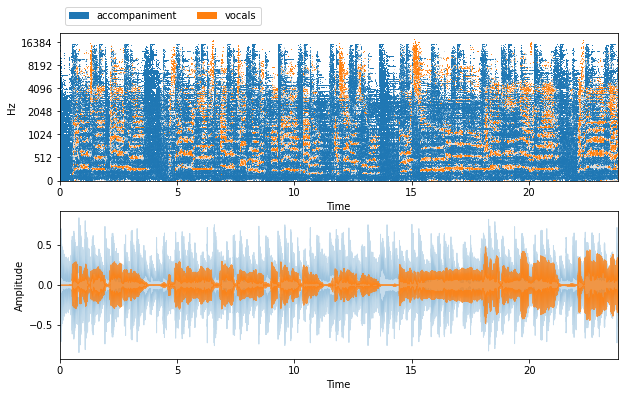


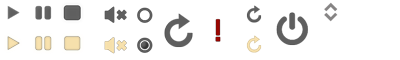
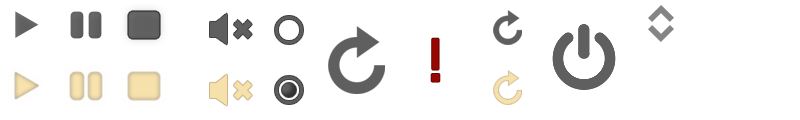
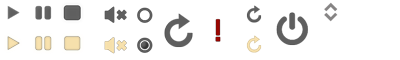

In [ ]:
visualize_and_embed(sources)

REPET

In [ ]:
repet = nussl.separation.primitive.Repet(audio_signal)

# Background and Foreground Masks
bg_mask, fg_mask = repet.run()
bg_mask_arr = bg_mask.mask
fg_mask_arr = fg_mask.mask

# Multiply the masks to the magnitude spectrogram
audio_signal.stft()



def apply_mask_with_noisy_phase(mix_stft, mask):
    mix_magnitude, mix_phase = np.abs(mix_stft), np.angle(mix_stft)
    src_magnitude = mix_magnitude * mask
    src_stft = src_magnitude * np.exp(1j * mix_phase)
    return src_stft

bg_stft = apply_mask_with_noisy_phase(audio_signal.stft_data, bg_mask_arr)
fg_stft = apply_mask_with_noisy_phase(audio_signal.stft_data, fg_mask_arr)


# Make new AudioSignals for background and foreground with phase
bg_phase = audio_signal.make_copy_with_stft_data(bg_stft)
background = bg_phase.istft()
fg_phase = audio_signal.make_copy_with_stft_data(fg_stft)
foreground = fg_phase.istft()

print('REPET Background with Phase')
_ = bg_phase.embed_audio()

print('REPET Foreground with Phase')
_ = fg_phase.embed_audio()

REPET Background with Phase


REPET Foreground with Phase


In [ ]:
sources = {
    'estimated vocals':fg_phase,
    'estimated accompaniment':bg_phase
}

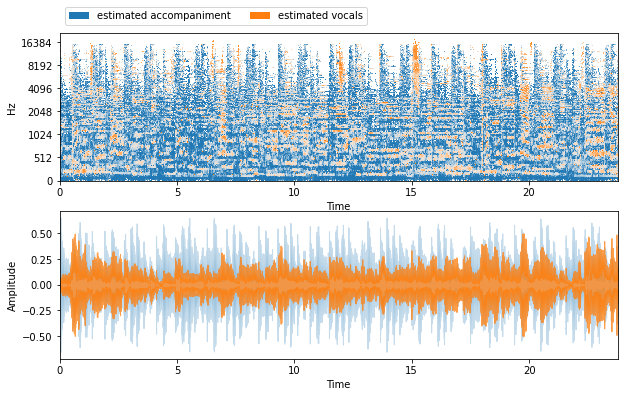


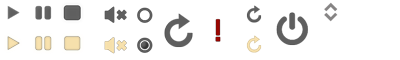
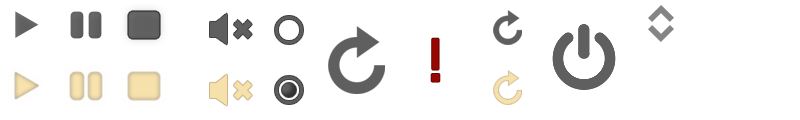
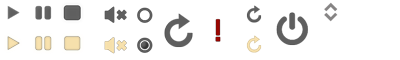

In [ ]:
visualize_and_embed(sources)

HPSS

In [ ]:
import librosa

In [ ]:
class MyHPSS(nussl.separation.base.MaskSeparationBase):
    
    def __init__(self, audio_signal, kernel_size=31, mask_type='soft',
                 mask_threshold=0.5):
        """Setup code goes here."""
        
        # The super class will save all of these attributes for us.
        super().__init__(
            input_audio_signal=audio_signal, 
            mask_type=mask_type,
            mask_threshold=mask_threshold
        )
        
        # Save the kernel size.
        self.kernel_size = kernel_size
        
    def run(self):
        """Code for running HPSS. Returns masks."""
        
        # Keep a list of each mask type.
        harmonic_masks = []
        percussive_masks = []

        # Our signal might have more than one channel:
        # Apply HPSS to each channel individually.
        for ch in range(self.audio_signal.num_channels):
            # apply mask
            harmonic_mask, percussive_mask = librosa.decompose.hpss(
                self.stft[:, :, ch], kernel_size=self.kernel_size, mask=True)
            harmonic_masks.append(harmonic_mask)
            percussive_masks.append(percussive_mask)

        # Order the masks correctly.
        harmonic_masks = np.stack(harmonic_masks, axis=-1)
        percussive_masks = np.stack(percussive_masks, axis=-1)
        _masks = np.stack([harmonic_masks, percussive_masks], axis=-1)
        
        # Convert the masks to `nussl.MaskBase` types.
        self.result_masks = []
        for i in range(_masks.shape[-1]):
            mask_data = _masks[..., i]
            if self.mask_type == self.MASKS['binary']:
                mask_data = _masks[..., i] == np.max(_masks, axis=-1)
            mask = self.mask_type(mask_data)
            self.result_masks.append(mask)

        # Return the masks>
        return self.result_masks
        

In [ ]:
my_hpss = MyHPSS(audio_signal)
hpss_estimates = my_hpss()
new = {}
# for i in range(2):
#     new[i] = hpss_estimates[i]


In [ ]:

sources = {
    'estimated vocals': hpss_estimates[0],
    'estimated accompaniment':hpss_estimates[1]

}

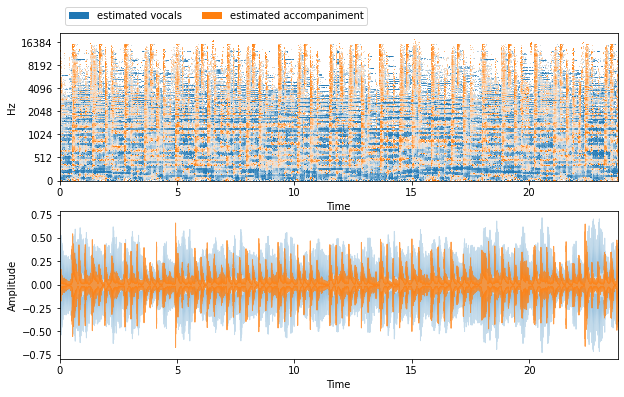


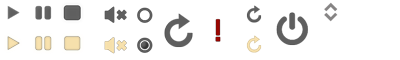
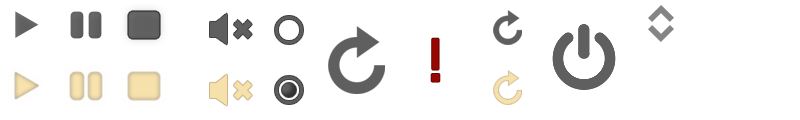
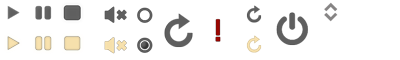

In [ ]:
visualize_and_embed(sources)